In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

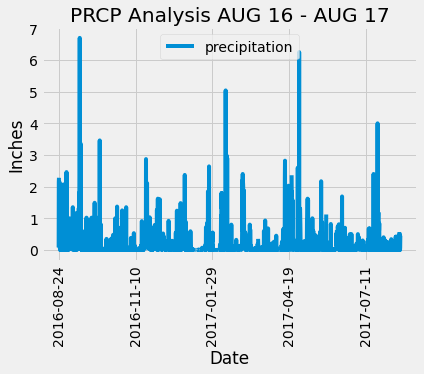

In [31]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
# date of last data point '2017-08-23'
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date
last_year = dt.date(2017,8,23) - dt.timedelta(days= 365)
last_year

# Perform a query to retrieve the data and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > last_year).\
order_by(Measurement.date.asc()).all()
prcp_query
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_query, columns=['date', 'precipitation'])

# Sort the dataframe by date
# Make date index
prcp_df.set_index('date', inplace= True)
prcp_df.sort_index(ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()
plt.title ('PRCP Analysis AUG 16 - AUG 17')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation =90)

plt.show()

In [40]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [41]:
# Design a query to show how many stations are available in this dataset?
stations_query = session.query(Station.station, Station.name).group_by(Station.name).all()
station_count = session.query(Station.station).count()
stations_query
station_count

9

In [42]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_activities = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# List the stations and the counts in descending order.
station_activities

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [43]:
# Most active station
most_active = station_activities[0][0]
most_active

'USC00519281'

In [44]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
# highest temperature recorded, and average temperature of the most active station?
stats = [Measurement.tobs, 
       func.max(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.avg(Measurement.tobs),
       func.count(Measurement.tobs)]

USC00519281_stats = session.query(*stats).\
    filter(Measurement.station == most_active).all()

USC00519281_stats

[(54.0, 85.0, 54.0, 71.66378066378067, 2772)]

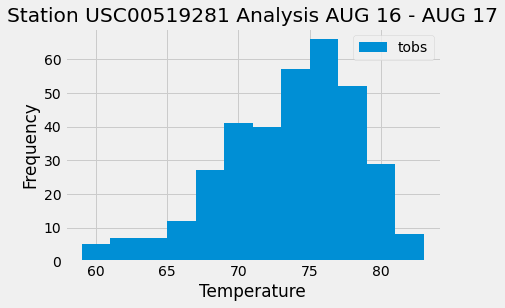

In [45]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
USC00519281_obs = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
filter(Measurement.station == most_active).\
filter(Measurement.date > last_year).\
order_by(Measurement.date.desc()).all()

#turn into df easier to work with
USC00519281_obs_df = pd.DataFrame(USC00519281_obs)
USC00519281_obs_df

#plot histogram
USC00519281_obs_df.plot.hist(bins = 12)
plt.title ('Station USC00519281 Analysis AUG 16 - AUG 17')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

In [46]:
USC00519281_obs_df.head()

,station,date,tobs
0,USC00519281,2017-08-18,79.0
1,USC00519281,2017-08-17,76.0
2,USC00519281,2017-08-16,76.0
3,USC00519281,2017-08-15,77.0
4,USC00519281,2017-08-14,77.0


## Bonus Challenge Assignment

In [47]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [48]:
# Establish a start and end date for trip (10 days)
trip_start = dt.date(2018,8,10)
trip_end = dt.date(2018,8,20)

In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_results = calc_temps('2017-08-10', '2017-08-20')

trip_results

[(70.0, 78.42222222222222, 85.0)]

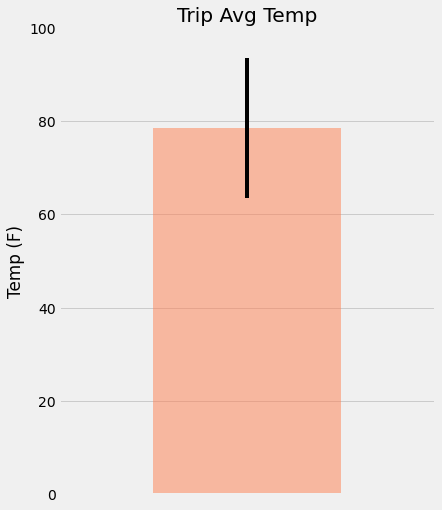

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# turn trip_results into df with 
trip_results_df = pd.DataFrame(trip_results, columns=['TMIN', 'TAVG', 'TMAX'])

avg_temp = trip_results_df['TAVG']
peak_to_peak = trip_results_df.iloc[0]['TMAX'] - trip_results_df.iloc[0]['TMIN']

avg_temp.plot(kind='bar', yerr=peak_to_peak, figsize=(6,8), alpha=0.5, color='coral')
plt.ylim(0,100)

plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xticks([])

plt.show()

In [51]:
# Calculate the total amount of rainfall per weather station for your trip dates(2018-08-10 to 2018-08-20) using the previous year's matching dates(2017).
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_rainfall = session.query(Station.station, Station.name, Station.latitude, Station.longitude,
                               Station.elevation, func.sum(Measurement.prcp)).\
    filter(Station.station == Measurement.station).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2017,8,10)).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) <= dt.date(2017,8,20)).\
    group_by(Station.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

#load into a dataframe - list the station, name, latitude, longitude, and elevation
trip_rainfall_df = pd.DataFrame(trip_rainfall, columns = ['station', 'name', 'latitude', 'longitude', 
                                                              'elevation', 'total rainfall'])
trip_rainfall_df

,station,name,latitude,longitude,elevation,total rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,1.49
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.51
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.26
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.02


In [52]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [53]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start = dt.date(2018,8,10)
trip_end = dt.date(2018,8,20)

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start,trip_end)

# Stip off the year and save a list of %m-%d strings
trip_dates_adj = trip_dates.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
#create a list to append to
normals_list = []
#loop & append
for trip_dates in trip_dates_adj:
    normals_list.append(*daily_normals(trip_dates))
normals_list

[(65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0),
 (69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0)]

In [54]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_list_df = pd.DataFrame(normals_list, columns=['TMIN', 'TAVG', 'TMAX'])
normal_list_df['DATE'] = trip_dates_adj
normal_list_df = normal_list_df.set_index('DATE')

normal_list_df

,TMIN,TAVG,TMAX
DATE,,,
08-10,65.0,76.420000,83.0
08-11,67.0,75.981132,82.0
08-12,67.0,76.527273,83.0
08-13,71.0,76.982456,84.0
08-14,71.0,76.777778,82.0
08-15,69.0,76.471698,83.0
08-16,69.0,76.080000,83.0
08-17,69.0,76.125000,83.0
08-18,70.0,76.923077,84.0


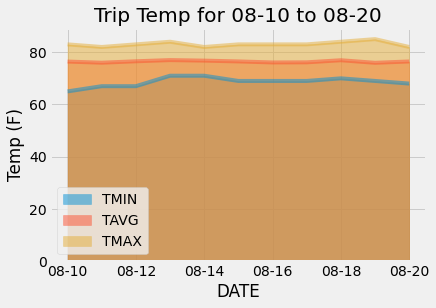

In [55]:
# Plot the daily normals as an area plot with `stacked=False`
normal_list_df.plot(kind='area', stacked=False)
plot.title("Trip Temp for 08-10 to 08-20")
plot.ylabel("Temp (F)")
plot.xticks()

plot.show(block=True)